# ANALYSIS - 2

# Which listings will yield maximum profit?

In [34]:
# cleaning the data

import pandas as pd
import numpy as np

inputDF = pd.read_csv('data/listings.csv')
inputDF=inputDF[['id','name','summary','longitude','latitude','space','description','instant_bookable','neighborhood_overview','neighbourhood_cleansed','host_id','host_name','host_since',
                 'host_response_time','street', 'zipcode','review_scores_rating','property_type','room_type','accommodates','bathrooms','bedrooms','beds','reviews_per_month','amenities','cancellation_policy','number_of_reviews','price']]


inputDF.fillna(0, inplace=True)


price = inputDF['price']
prices=[]


for p in price:
    p=float(p[1:].replace(',',''))
    prices.append(p)


inputDF['price']=prices


inputDF = inputDF[inputDF.bathrooms >0]
inputDF = inputDF[inputDF.bedrooms > 0]
inputDF = inputDF[inputDF.beds > 0]
inputDF = inputDF[inputDF.price  > 0]
inputDF = inputDF[inputDF.review_scores_rating  > 0]
inputDF = inputDF[inputDF.reviews_per_month > 0]
inputDF = inputDF[inputDF.accommodates  > 0]

In [35]:
# Average price for each listing type

avgPrice_DF=inputDF.groupby('room_type').price.mean()
avgPrice_DF=avgPrice_DF.reset_index()
avgPrice_DF=avgPrice_DF.rename(columns={'price':'average_Price'})
avgPrice_DF

,room_type,average_Price
0,Entire home/apt,286.464240
1,Hotel room,276.606061
2,Private room,159.149784
3,Shared room,114.838710


It can be concluded that Entire home/Apartment room type has the maximum average price. Therefore, after buying an Apartment/Home, listing the entire unit on Airbnb will help to generate maximum revenue. 

In [36]:
#Which area in San Francisco has maximum listings on Airbnb?

# seggregating each type of property

home = inputDF[(inputDF.room_type == 'Entire home/apt')]
private = inputDF[(inputDF.room_type == 'Private room')]
shared = inputDF[(inputDF.room_type == 'Shared room')]

# Geographical Clusters 

location_home = home[['latitude', 'longitude']]
location_private = private[['latitude', 'longitude']]
location_shared = shared[['latitude', 'longitude']]

In [37]:
# grouping neighbourhood by number of listings

neighbourhood_DF=home.groupby('neighbourhood_cleansed').id.count()
neighbourhood_DF=neighbourhood_DF.reset_index()
neighbourhood_DF=neighbourhood_DF.rename(columns={'id':'Number_Of_Listings'})
neighbourhood_DF=neighbourhood_DF.sort_values('Number_Of_Listings',ascending=[0])
neighbourhood_DF.head()

,neighbourhood_cleansed,Number_Of_Listings
16,Mission,308
34,Western Addition,241
2,Castro/Upper Market,219
1,Bernal Heights,207
30,South of Market,197


In [38]:
# grouping neighbourhood by average price of listings

neighbourhoodPrice_DF=home.groupby('neighbourhood_cleansed').price.mean()
neighbourhoodPrice_DF=neighbourhoodPrice_DF.reset_index()
neighbourhoodPrice_DF=neighbourhoodPrice_DF.rename(columns={'price':'Average_Price'})
neighbourhoodPrice_DF=neighbourhoodPrice_DF.sort_values('Average_Price',ascending=[0])
neighbourhoodPrice_DF.head()

,neighbourhood_cleansed,Average_Price
27,Presidio Heights,592.687500
15,Marina,444.000000
13,Inner Sunset,426.809524
24,Pacific Heights,417.313253
31,Twin Peaks,396.450000


In [39]:
#Merging above two dataframes

mergeDF=pd.merge(neighbourhood_DF,neighbourhoodPrice_DF,on='neighbourhood_cleansed')
mergeDF.head()


,neighbourhood_cleansed,Number_Of_Listings,Average_Price
0,Mission,308,282.944805
1,Western Addition,241,326.037344
2,Castro/Upper Market,219,302.420091
3,Bernal Heights,207,229.850242
4,South of Market,197,260.197970


Text(0, 0.5, 'Number Of Listings')

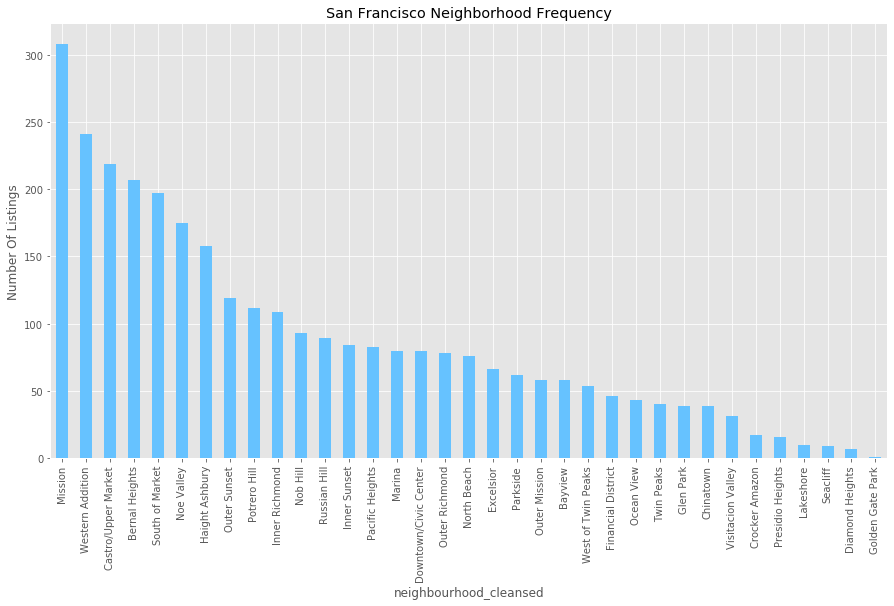

In [40]:
# visualizing the frequency of listings on the basis of neighbourhood where room type is entire apartment

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

objects = neighbourhood_DF['neighbourhood_cleansed']
y_pos = neighbourhood_DF['Number_Of_Listings']

neighbourhood_DF.plot(kind='bar', 
           x='neighbourhood_cleansed',
           y='Number_Of_Listings',
           color = '#66c2ff', 
           figsize =(15,8), 
           title = 'San Francisco Neighborhood Frequency', 
           legend = False)

plt.ylabel('Number Of Listings')

It can be noticed that the maximum number of listings for entire apartment/home for San Francisco on Airbnb is in Mission area followed by Western Addiction and Castro/Upper Market. So these areas become potential neighbourhoods for property investment. 

Text(0, 0.5, 'Average Price')

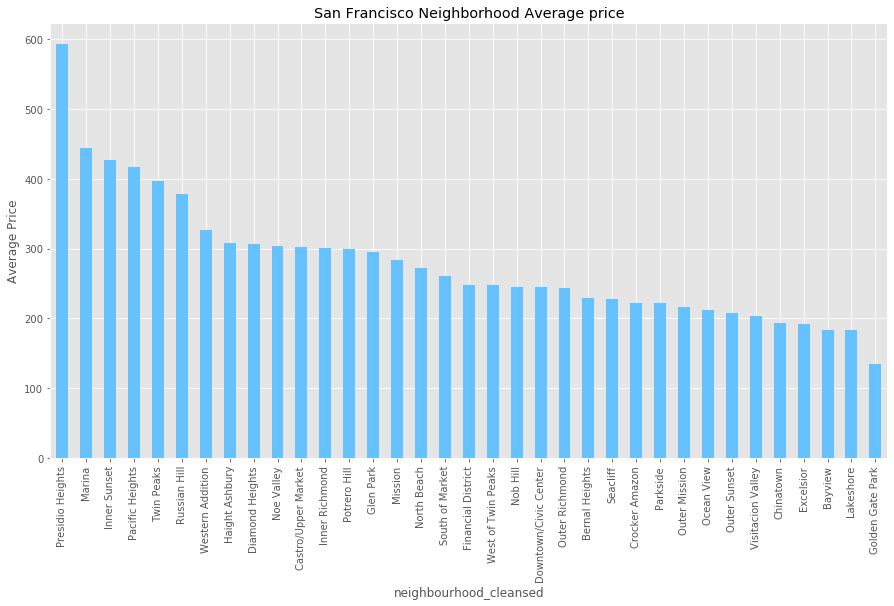

In [41]:
# Now lets visualize average price of these listings on the basis of neighbourhood where room type is entire apartment

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

objects = neighbourhoodPrice_DF['neighbourhood_cleansed']
y_pos = neighbourhoodPrice_DF['Average_Price']

neighbourhoodPrice_DF.plot(kind='bar', 
           x='neighbourhood_cleansed',
           y='Average_Price',
           color = '#66c2ff', 
           figsize =(15,8), 
           title = 'San Francisco Neighborhood Average price', 
           legend = False)

plt.ylabel('Average Price')

By analyzing the number of listings and prices per neighborhood, we can get a clearer understanding of how accurate the average price is per neighborhood. The neighorhoods with a lot of listings such as Mission area, Western Addiction and Castro/Upper Market), we can expect a more accurate average price. However, neighborhoods with less than 100 listings might have relatively inaccurate average prices due to presence of outliers.

In [42]:
# Finding highly occuring keywords in different neighbourhoods in San Francisco


import re
import nltk
from nltk.corpus import stopwords
from collections import Counter

nltk.download('wordnet')

uniqueNeighborhoods = inputDF.neighbourhood_cleansed.unique().tolist()

#function to clean the data and compile a list of most common words
def cleanData(neighbrhood_name,descrip):
    p = re.sub('[^a-zA-Z]+',' ', descrip)
    cmn_words=['The','I','San','Francisco','room']
    descrip_data=nltk.word_tokenize(p)
    filtered_data=[word.lower() for word in descrip_data if word not in cmn_words if word not in stopwords.words('english')] 
    wnl = nltk.WordNetLemmatizer() 
    counts=Counter([wnl.lemmatize(data) for data in filtered_data])
    commn_words=[]
    for w in counts.most_common(5):
        commn_words.append(w[0])
    return ' '.join(commn_words)

summ={}
for n in uniqueNeighborhoods:
    text=''
    for index,row in inputDF.iterrows():
        if row['neighbourhood_cleansed']==n:
            if ((row['description']!=0) & (row['space']!=0) & (row['neighborhood_overview']!=0)):
                text =text+row['description']+row['space']+row['neighborhood_overview']
    summ[n]=text

final_DF_neighbrhood=pd.DataFrame(columns=['neighborhood','top 5 words in description'])
for a in summ.items():
    top5words=cleanData(a[0],a[1])
    final_DF_neighbrhood=final_DF_neighbrhood.append(pd.Series([a[0],top5words],index=['neighborhood','top 5 words in description']),ignore_index=True)

#final_DF_neighbrhood.to_csv('top_words_description.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
final_DF_neighbrhood

,neighborhood,top 5 words in description
0,Western Addition,bedroom park kitchen home neighborhood
1,Bernal Heights,bernal bedroom height neighborhood street
2,Haight Ashbury,haight park bedroom neighborhood bed
3,Mission,mission bedroom kitchen restaurant street
4,Potrero Hill,hill view potrero bedroom neighborhood
5,Downtown/Civic Center,check desk square bedroom room
6,Castro/Upper Market,castro bedroom neighborhood street park
7,Inner Sunset,bedroom park golden gate neighborhood
8,South of Market,apartment bedroom kitchen building block
9,Nob Hill,hill nob kitchen street located


It can be observed that for neighborhood "Mission" major words include kitchen, "Western Addition" includes park, "Castro/Upper Market" includes bedroom. While listing the property on airbnb these words should definitely be included to attract travellers.

After combining all the data points collected from above analysis it can be concluded that:

1. After buying an Apartment/home, listing the entire unit on Airbnb will help to generate maximum revenue.
2. Invest in a property in "Mission", "Western Addition" or "Castro/Upper Market" neighborhood as they have maximum number of listings and average prices in these neighborhood is fairly high.
3. While listing the property on AirBnB, keywords describing the area should be added in order to gain the attention of travellers.